# ReadMe

Questo notebook si occupa di convertire il dataset in formato NPZ, in modo da renderlo velocemente acquisibile. <br>
Viene fissata una cartella <code>processed_dataset</code> la quale andrá a contenere il dataset rifinito a partire dal contenuto della cartella <code>raw_dataset</code>


In [134]:
raw_dataset        = "../PocketAnalysis/refined"
processed_dataset  = "processed_data"

## Oggetti costruiti

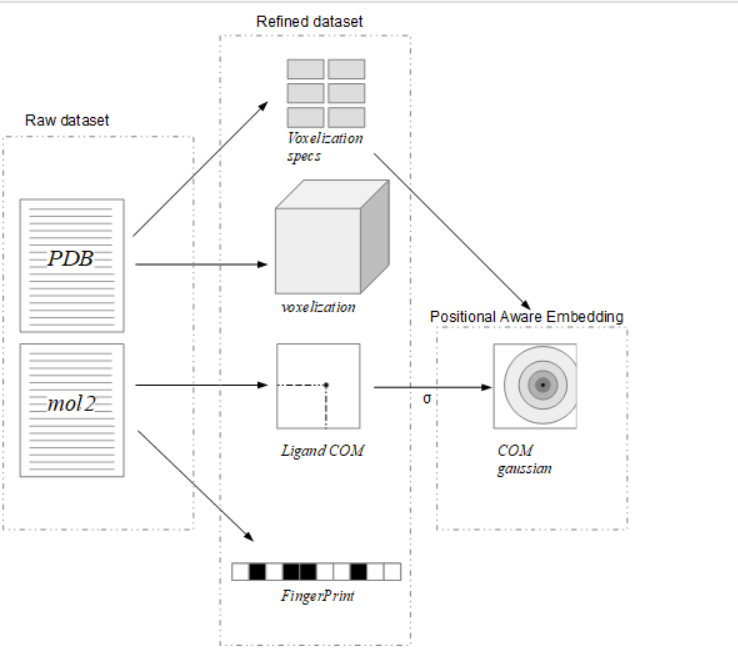

## Conteggio dei samples

In [135]:
import os

samples = 0
for root, dirnames, filenames in os.walk(raw_dataset):
        for dirname in dirnames:
            samples +=1
samples            

1241

## Estrazione della voxelizzazione

representation...


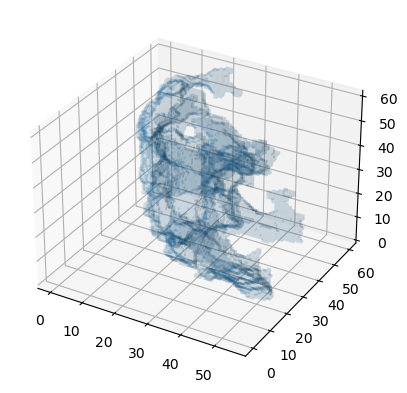

In [145]:
def extract_voxelization(filename):
    X = list()                            # coordinate atomiche
    
    file1 = open(filename, 'r')           # leggo il file
    Lines = file1.readlines()             # estraggo le linee
    
    sparse = list()                       # rappresentazione sparsa delle coordinate che descrivono la tasca
    
    x_min,y_min,z_min,x_max,y_max,z_max = 0,0,0,0,0,0
    
    for line in Lines:
        if line.startswith("GRIDG"):
            data = np.array(line.split()[2:]).astype(float)
            x_min,y_min,z_min,x_max,y_max,z_max = data[0],data[1],data[2],data[3],data[4],data[5]
        if line.startswith("GRIDVX"):
            coords = np.array(line.split()[1:4]).astype(int)
            if line.split()[-2] == 'P':
                sparse.append(coords)
    
    sparse = np.array(sparse).astype(int)
    
    grid = np.zeros( (
        np.max(sparse[:,0])+1,
        np.max(sparse[:,1])+1,
        np.max(sparse[:,2])+1
        )
    )
    
    for s in sparse:
        grid[s[0],s[1],s[2]] = 1.
    
    specs = np.array([x_min,x_max,y_min,y_max,z_min,z_max])
    return grid, specs

vox,specs = extract_voxelization(raw_dataset + r"\1ezq\1ezq_pocket.ligen.pdb")
print("representation...")
ax = plt.figure().add_subplot(projection = '3d')
ax.voxels(vox, alpha = 0.1)
plt.show()

##  Estrazione dei dati relativi al ligando

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator



class AtomicStructure:
    def __init__(self, file_path):
        self.load_periodic_table()
        self.coords_list,self.atom_list = self.get_atom_coordinates_and_types(file_path)
        self.file_path   = file_path
        
    def get_atom_coordinates_and_types(self, filename):
        X = list()                            # coordinate atomiche
        A = list()                            # atom list

        file1 = open(filename, 'r')           # leggo il file
        Lines = file1.readlines()             # estraggo le linee

        reading_atoms = False
        for line in Lines:
            if line.startswith('@<TRIPOS>ATOM'):
                reading_atoms = True
            else:
                if reading_atoms:
                    if line.startswith("@<TRIPOS>BOND"):
                        break
                    else:
                        tokenized = line.split()
                        A.append(tokenized[5].split('.')[0])
                        X.append(tokenized[2:5])

        X = np.array(X).astype(float)
        A = np.array(A)

        return X,A
        
    def compute_center_of_mass(self):
        w = np.array([
                self.atom_weight[atom_type]
            for atom_type in self.atom_list
        ])
        return (w[:,None] * self.coords_list).sum(axis = 0) / w.sum()
    
    def compute_finger_print(self):
        m   = Chem.rdmolfiles.MolFromMol2File(self.file_path)
        fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2)
        fp1 = fpgen.GetFingerprint(m)
        fp1 = np.array([bit for bit in fp1])
        return fp1
    
    def load_periodic_table(self):
        pt = pd.read_csv("periodic_table.csv").to_numpy()
        self.atom_weight = {}
        for atom_data in pt:
            atom_name                   = atom_data[2]
            atom_weight                 = atom_data[3]
            self.atom_weight[atom_name] = atom_weight
    
    def draw(self):     
        size = np.array([
                self.atom_weight[atom_type]
            for atom_type in self.atom_list
        ])
        
        atomi_unici = np.unique(self.atom_list)
        

        ax = plt.figure(figsize =(10,10)).add_subplot(projection = '3d')
        ax.scatter(
            self.coords_list[:,0],
            self.coords_list[:,1],
            self.coords_list[:,2],
            s = size
        )
        
        com = self.compute_center_of_mass()
        ax.scatter(
            com[0],
            com[1],
            com[2],
            color = 'red'
        )
        

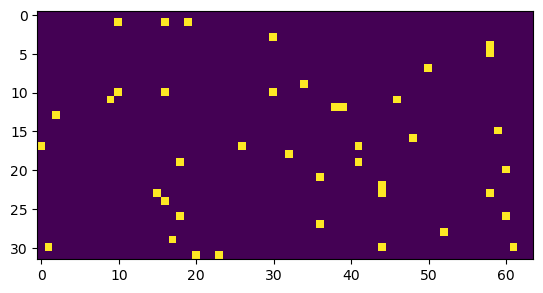

In [138]:
atomic_structure  = AtomicStructure(raw_dataset + "/1a69/1a69_ligand.mol2")
fp                = atomic_structure.compute_finger_print()
plt.imshow( fp.reshape(2**5,2**6) )

## Loop di caricamento dei dati

In [140]:
voxelization_specs  = []    # specifiche delle voxelizzazioni
voxelizations       = []    # contiene le voxelizzazioni
centers_of_mass     = []    # contiene i centri di massa
finger_prints       = []    # contiene le fingerprints

count = 0
N     = 100             # quanti sample caricare dal dataset?


for root, dirnames, filenames in os.walk(raw_dataset):    
        for dirname in dirnames:
            try:
                if count > N:
                    break
                    
                # trovo il path del ligando
                ligand_name       = dirname + "\\" + dirname+"_ligand.mol2"
                whole_ligand_path = "%s\\%s" % (root,ligand_name)
                
                atomic_structure  = AtomicStructure(whole_ligand_path)
                COM               = atomic_structure.compute_center_of_mass()
                finger_print      = atomic_structure.compute_finger_print()
                
                
                # trovo il path della tasca
                pocket_name       = dirname + "\\" + dirname+"_pocket.ligen.pdb"
                whole_pocket_path = '%s\\%s' % (root,pocket_name)
                vox,vox_specs     = extract_voxelization(whole_pocket_path)
                
                centers_of_mass.append(COM)
                finger_prints.append(finger_print)
                voxelizations.append(vox)
                voxelization_specs.append(vox_specs)
                
                count += 1
                
                if int((count)/(N/ 10)) != int( (count + 1) / (N/ 10) ) :
                    print(count)
                
            except KeyboardInterrupt:
                break

9
19
29
39
49
59
69
79
89


[16:27:43] 1bq4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


99


# Salvataggio in formato NPZ

In [146]:
for i, voxelization,voxelization_spec,center_of_mass, finger_print in zip(
                                        range(len(voxelizations)),   # enumeratore
                                        voxelizations,               # voxelizzazioni
                                        voxelization_specs,          # specifiche delle voxelizzazioni
                                        centers_of_mass,             # centri di massa
                                        finger_prints                # finger prints delle molecole
                                        ):
        
    np.save("%s/voxelizations/voxelization_%d"   % (processed_dataset,i),  np.array(voxelization))
    np.save("%s/voxelization_specs/voxelization_spec_%d"   % (processed_dataset,i),  np.array(voxelization_spec))
    np.save("%s/centers_of_mass/center_of_mass_%d" % (processed_dataset,i),  np.array(center_of_mass))
    np.save("%s/finger_prints/finger_print_%d"          % (processed_dataset,i),  np.array(finger_print))

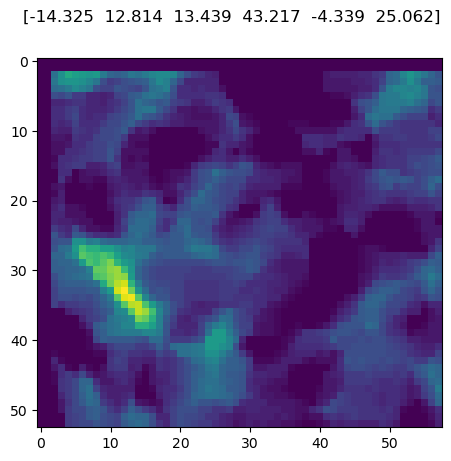

In [144]:
plt.figure()
sample = 47
plt.suptitle("%s" % voxelization_specs[sample])
plt.imshow(voxelizations[sample].mean(axis = 2))

In [24]:

pd.read_csv("periodic_table.csv").to_numpy()[1]

array([2, 'Helium', 'He', 4.002, 2, 2, 2, 1, 18.0, 'gas', nan, 'yes', nan,
       'yes', nan, 'Noble Gas', 0.49, nan, 24.5874, 0.000179, nan, 4.22,
       5.0, 'Janssen', 1868.0, 5.193, 1, nan], dtype=object)